# Algorithmia Integration Notebook

Let's get started on using Arize with Algorithmia!✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models. Algorithmia is a platform for model serving and help you manage machine learning at scale.

In this notebook, we show that we can quickly create a model and download it to serve on Algorithmia, and integration with Arize platform can be done directly on Algorithmia, without needing any environment dependency aside from Algorithmia from user environment.

1. **Step 1-2:** creates a basic model and downloads it as a .pkl file to be loaded on Algorithmia.
2. **Step 3-4:** Developing and testing Algorithmia + Arize API locally
2. **Step 5 (Outside Notebook):** Develop and build for "server-side" on Algorithmia
3. **Step 6:** Test from "client-side" that the model executes properly!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Arize-ai/client_python/blob/main/arize/examples/tutorials/Arize_Tutorial_Algorithmia_Integration_v2.ipynb)

## Step 1: Load Data and Build Model

In [1]:
import numpy as np
import pandas as pd
import uuid
import concurrent.futures as cf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

###############################################################################
# 1 Load data and split data
from sklearn import datasets
data = datasets.load_breast_cancer()
X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = pd.DataFrame(X.astype(np.float32), columns=data['feature_names']), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
###############################################################################
# 2 Fit a simple logistic regression model
clf = LogisticRegression(max_iter=3000, verbose=False).fit(X_train, y_train)

# 3 Use the model to generate predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Step 1 ✅: Load Data & Build Model Done!')

Step 1 ✅: Load Data & Build Model Done!


## Step 2: Download Model for Serving on Algorithmia
There are other ways to serve model on Algorithmia. Saving it as a `model.pkl` file and reloading the model is one way to do this.

In [2]:
import pickle
from google.colab import files

# Creating the pickle file
model_name = "Algorithmia_Tutorial_Model"
filename = "{}.pkl".format(model_name)
pickle.dump(clf, open(filename, 'wb'))

## Download file from Colab
files.download(filename)
print('Step 2 ✅: The file should have been successfully downloaded!')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 2 ✅: The file should have been successfully downloaded!


## Step 3: Explainability and SHAP Values
**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model.

For more in-depth usage of the `shap` library, visit [SHAP Core Explainers](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.Explainer.html). We will need to install the library to test that we can are properly generating `SHAP` values for explainability.

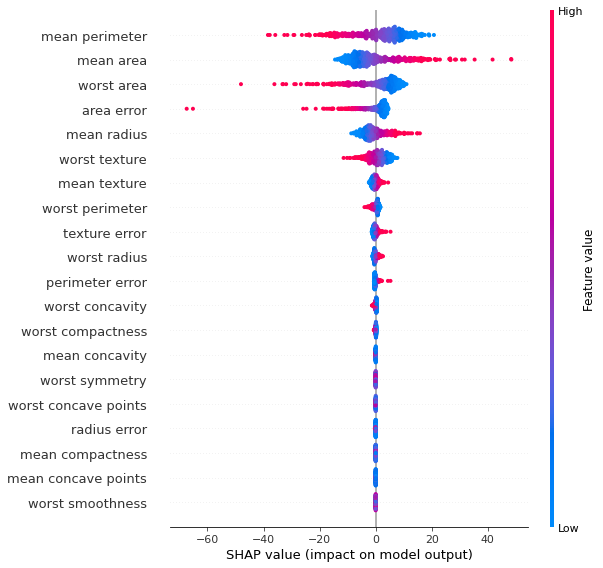

In [3]:
!pip install shap
import shap
def get_shap_values(model, X_data, ExplainerType=shap.Explainer, show_graph=False):
    # NOTE: If there are errors, you  need to manually choose which explainer class
    explainer = ExplainerType(model, X_data)
    shap_values = explainer.shap_values(X_data)

    # When not in production, it can be helpful to check graphs for feature explainability
    if show_graph:
        shap.summary_plot(shap_values, X_data, feature_names=data['feature_names'])

    # NOTE: Arize API expects a DataFrame of the same shape and column name as the model features.
    return pd.DataFrame(shap_values, columns=data['feature_names'])

shap_values = get_shap_values(clf, X, show_graph=True)
print('Step 3 ✅: If no errors showed up, you should see a SHAP Graph above here!')

## Step 4: Integrate Arize with Algorithmia Server Side

In order test Arize integration before serving your model, you need to find your `API_KEY` and `SPACE_KEY` by navigating to the settings page in your workspace (only space admins can see the keys). You will also need your Algorithmia API Key from your [Algorithmia Home Page](https://algorithmia.com/users).

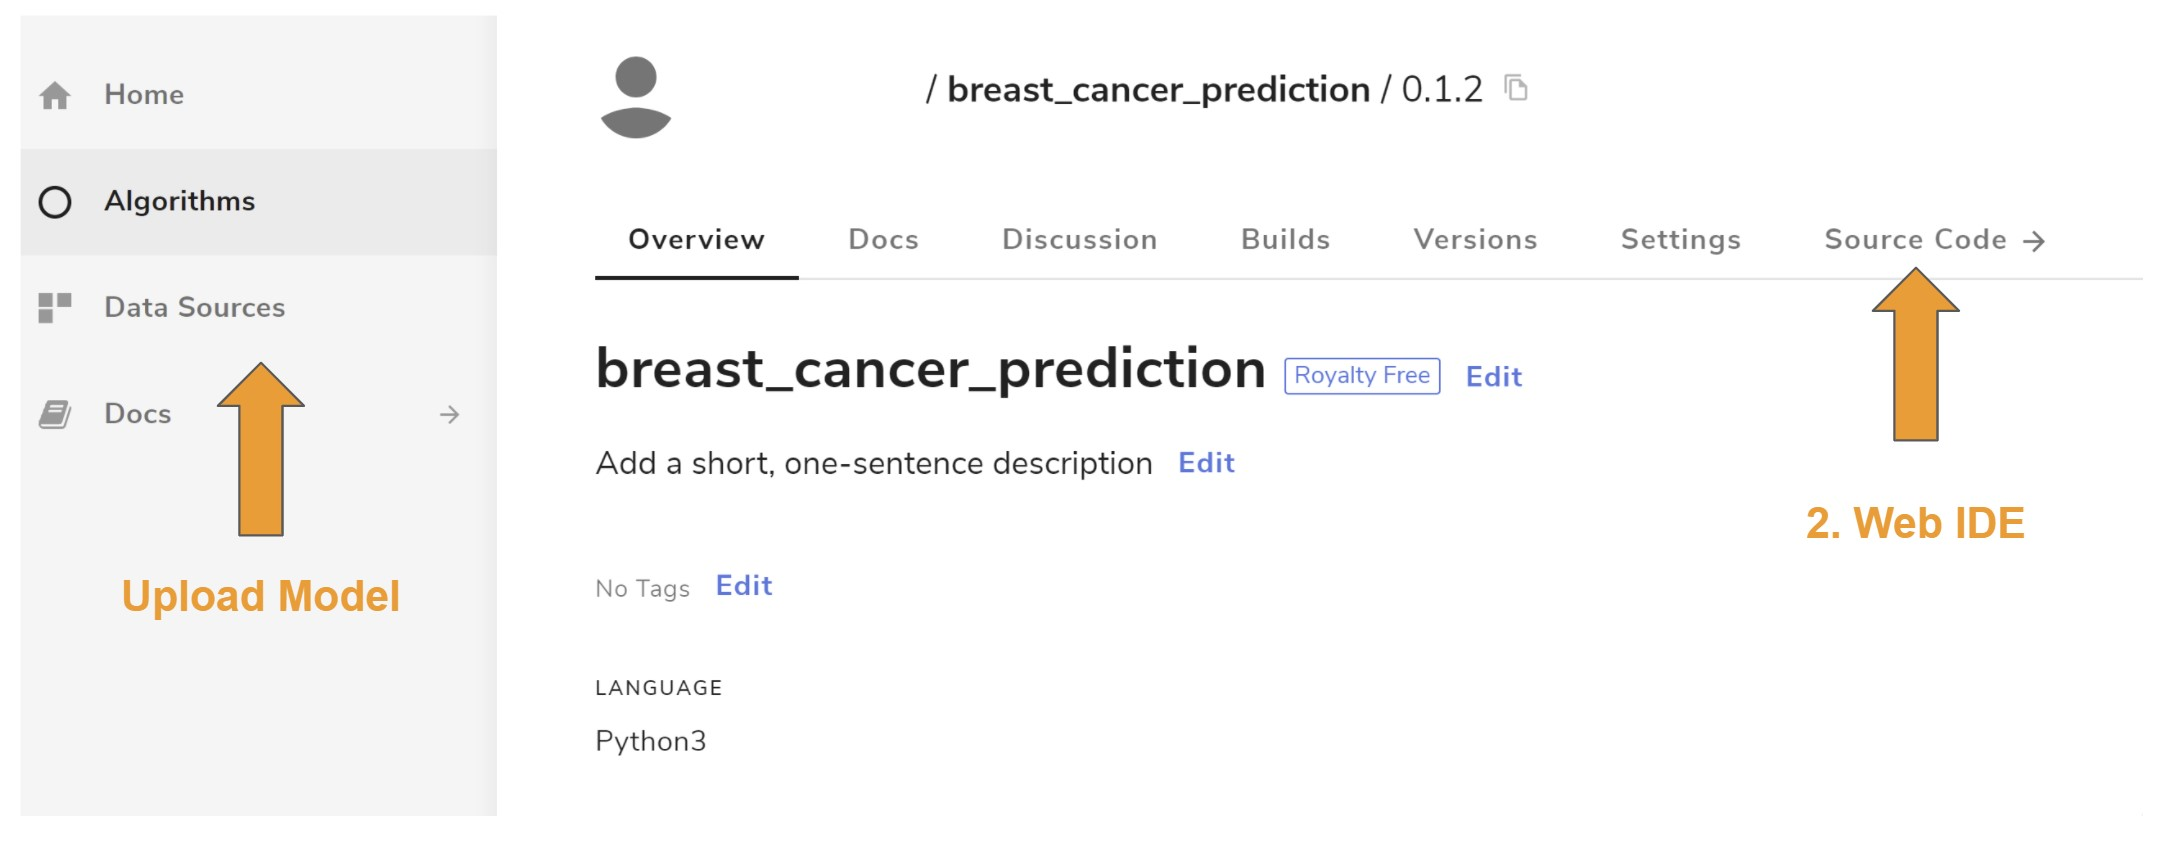

1. Upload `Algorithmia_Tutorial_Model.pkl` to your [Data Center](https://algorithmia.com/data/hosted/), and click the vertical elipsis, and then click `Copy Path`. Save as as the `filename` in the below cell.
2. **IMPORTANT:** Copy the below cell along with the proper `API_KEY`, `SPACE_KEY`, and algorithmia credentials into the **Algorithmia IDE**
3. Add the following dependencies on Algorithmia:
    `algorithmia>=1.0.0,<2.0`
    `arize>=2.1.1`
    `pandas<2,>=0.25.3`
    `joblib==1.0.1`
    `shap==0.39.0`
    `scikit-learn`


In [4]:
import Algorithmia
import shap
import pandas as pd
import uuid
import sklearn
import joblib
import pickle
from arize.api import Client
from arize.utils.types import ModelTypes

# setting up arize client
def load_model(filename, algorithmia_key):
    client = Algorithmia.client(algorithmia_key)
    model_name = client.file(filename).getFile().name
    model = joblib.load(model_name)
    return model

filename = "YOUR_COPIED_FILE_PATH"
space_key = 'YOUR_ARIZE_SPACE_KEY'
api_key = 'YOUR_ARIZE_API_KEY'
algorithmia_api_key = 'YOUR_ALGORITHMIA_KEY'

arize_client = Client(space_key=space_key, api_key=api_key)
model = load_model(filename, algorithmia_api_key)


def apply(input):
    # Generate new predictions in production
    X_data = pd.read_json(input)
    y_pred = model.predict(X_data)

    shap_values = shap.Explainer(model, X_data).shap_values(X_data)
    shap_values = pd.DataFrame(shap_values, columns=X_data.columns)

    ids = pd.Series([str(uuid.uuid4()) for _ in range(len(X_data))])

    # We log the data to Arize after making prediction
    log_responses = arize_client.log_bulk_predictions(
        model_id="Algorithmia_Tutorial_Model",
        model_version="1.0",
        model_type=ModelTypes.BINARY,
        features=X_data,
        prediction_ids=ids,
        prediction_labels=pd.Series(y_pred))

    # We log the data to Arize after making prediction
    shap_responses = arize_client.log_bulk_shap_values(
        model_id="Algorithmia_Tutorial_Model",
        prediction_ids=ids, # Again, pass in the same IDs to match the predictions & actuals.
        shap_values=shap_values
    )

    # return prediction for and the prediction id for each
    res = pd.DataFrame(y_pred)
    res.index = ids
    res.index.rename("pred_id", inplace=True)
    return res.to_json()

Step 3 ✅: If no errors showed up, you should see a SHAP Graph above here!


This following cell simulates a `pipe` call from `Algorithmia.client`. If we verify that it works, we can copy the above code directly in to `your_algo_name.py` file and serve it on algorithmia platform

In [5]:
result = pd.read_json(apply(X_test.to_json()))
print('Step 4 ✅: This is an example of how Algorithmia would return your production example!')
result

Step 4 ✅: This is an example of how Algorithmia would return your production example!


,0
00867b89-36a6-4ee6-9e2b-d5061508c8e7,1
017c530d-ccd3-44ec-a7c8-17aa205ea4a9,1
056d950a-aacc-4605-bb9e-e707c086f92c,0
057ee525-d5dd-4442-bd48-b0584942a20f,1
06ab42e3-330f-4bc0-a164-1007e8d5da41,0
...,...
f9b037d3-ba27-47eb-8547-b16c99908e94,0
fa117622-db39-49eb-ba35-7ab8636c7bf1,0
fcd296d6-147a-4e36-88bc-ee0792044d6b,1
fe7ae90a-48d7-4c41-9734-914628a36680,1


## Step 5 (On Algorithmia): Upload the Model & Develop on Algorithmia
Next, follow these steps to build and deploy on Algorithmia:
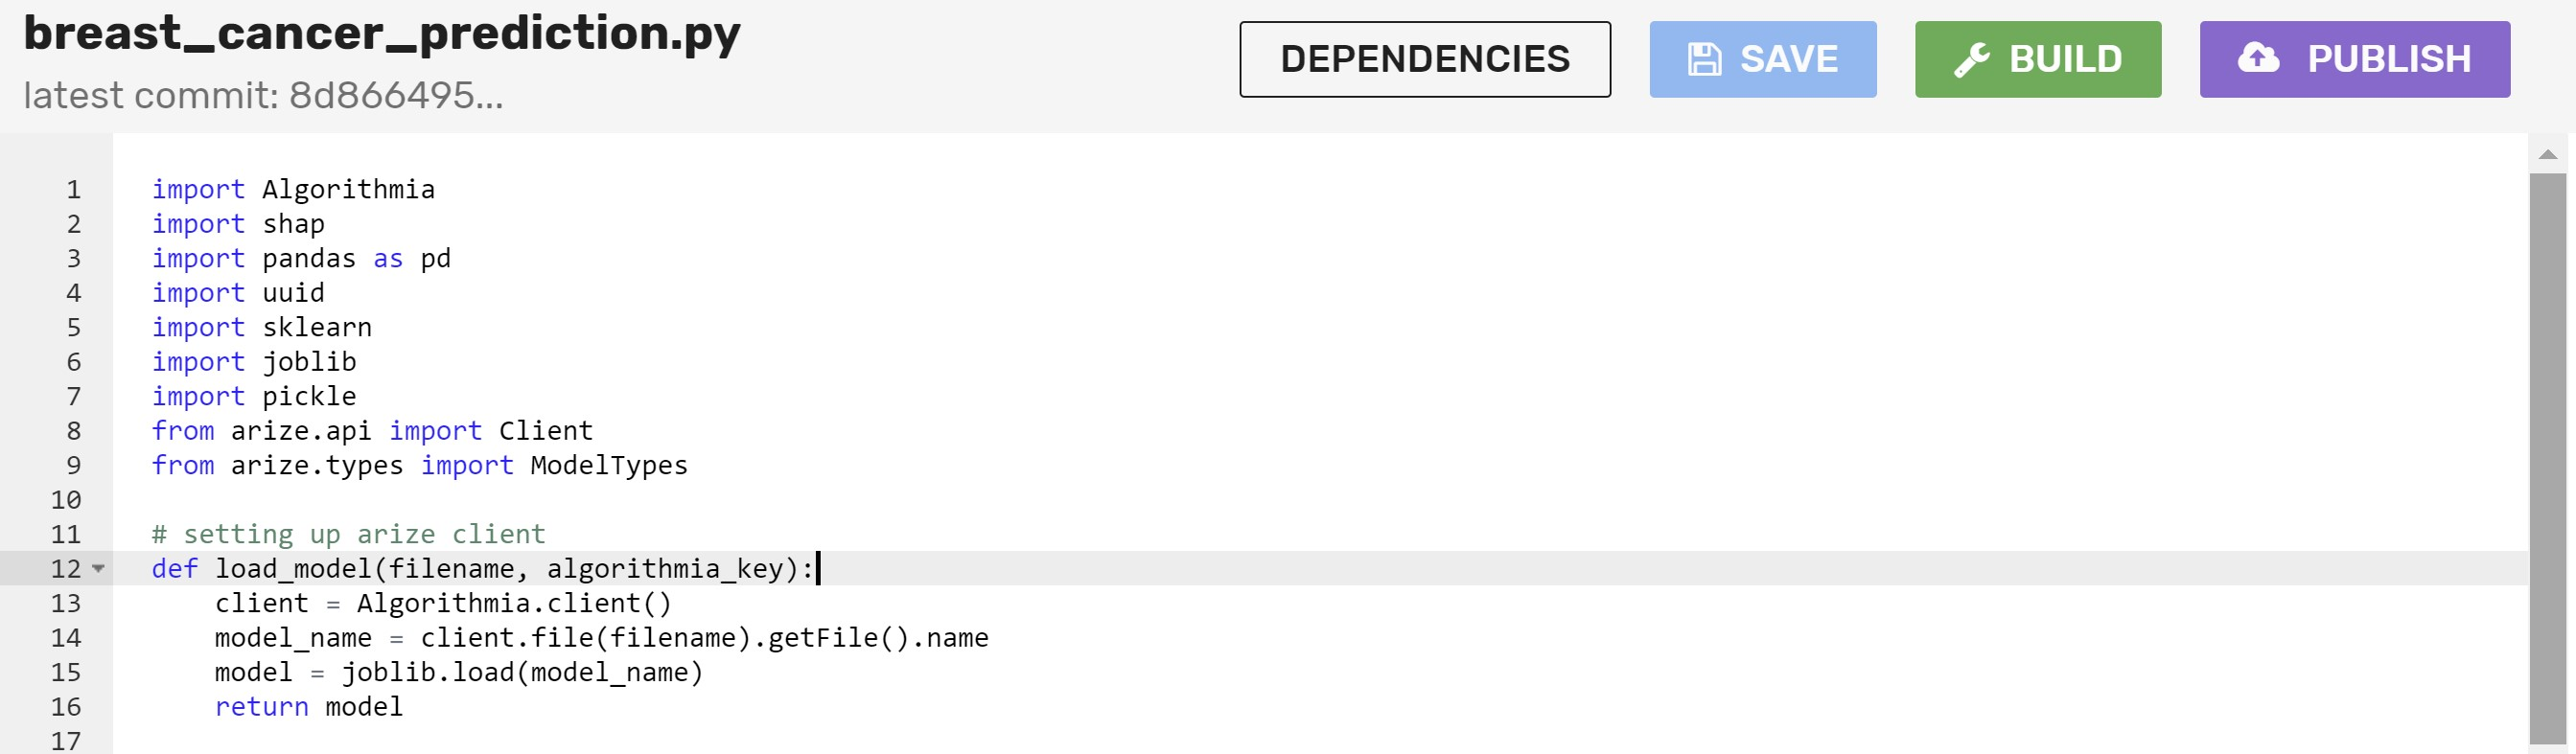
1. Create a [new algorithm](https://algorithmia.com/users) on Algorithmia with standard Python 3.0 environment.
2. Enter these are your depencies, then click `Build` and wait for it to execute successfully, then **Publish** it.
3. Click `Build` and see the model compiles successfully.

## Step 6: Testing Algorithmia API
Next, we test and simulate an API call to algorithmia to
1. Obtain the prediction made by our model, deployed and ran on Algorithmia
2. Log our production features and results to Arize platform. No need for client to install anything!

To get your Algorithmia API and algorithm name, go to "ALGO_NAME/Install and Use/Python/Use"

Then, check on Arize that the model predictions and `SHAP` values are all logged. The returned results includes the `pred_id` which we can then use to log the `actuals` when label become avaliable.

In [6]:
import Algorithmia

# Create a dummy tutorial
_, X_test_2, _, y_test_2 = train_test_split(X, y, test_size=0.02)

ALGO_API_KEY = 'ALGO_API_KEY' # TODO: put your Algorithmia API Key
ALGO_ALG_NAME = 'USERNAME/ALGO_ALG_NAME/VERSION' # TODO: put your algorithm name, as shown on API call documentation

# Note: input must be json formatted
input = X_test.to_json()
client = Algorithmia.client(ALGO_API_KEY)
algo = client.algo(ALGO_ALG_NAME)
algo.set_options(timeout=60) # optional, for your testing purposes

# Actual format shape of input for pipe(input) should depend on your algorithm
res = algo.pipe(input).result

# Result should also be json formatted
pd.read_json(res)

,0
0034f30c-51db-4ba3-9d83-23ee40ab58c1,1
0136a14d-aa2a-4180-bfa0-0e69725411af,1
01c4070b-ecc0-4ca3-bd75-4c7d97fb94cf,1
067666fa-be3d-4aee-a07d-b443d2da524c,0
0e47eb6e-1bbd-4590-bd66-a2636b78ce07,1
...,...
f1f0c8c4-72aa-4b88-a9e4-98b922214608,0
f4e5bba5-9c65-48b6-b10d-992e48da34ee,0
fafaee90-3975-4571-a053-76dafe408d8f,0
fceec915-9051-4ce8-9cea-56e001799737,0


### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
